In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = None
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sklearn.metrics as m
from matplotlib import pyplot
from keras import backend as K

In [20]:
data_path = 'data/flat_data.npy'
#data_path = 'data/flat_data_extra.npy'


# load data from .npy files into numpy arrays
data = np.load(data_path)
samples = len(data)
time_steps = 20
features = 107


X = data[:,2:].reshape((samples, time_steps, features))
Y = data[:, 1:2].reshape((samples))

epochs = 40
batch_size = 10


In [21]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.30, random_state=42)

In [22]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

unique, counts = np.unique(Y, return_counts=True)
class_weight={
    1: counts[0] / counts[1] * 1
}
class_weight

{1: 24.571428571428573}

In [23]:
# build LSTM layers
model = Sequential()
model.add(LSTM(100, dropout=0.2, input_shape=(time_steps, features)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[specificity, sensitivity])
print(model.summary())
model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=epochs, batch_size=batch_size, verbose=0)

print('done')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               83200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 83,301
Trainable params: 83,301
Non-trainable params: 0
_________________________________________________________________
None
done


In [24]:
yhat = model.predict_classes(test_X)
# score model and log accuracy and parameters
scores = model.evaluate(test_X, test_Y, verbose=0)
probs = model.predict(test_X)
precision, recall, thresholds = m.precision_recall_curve(test_Y, probs)

print("Accuracy: %.2f%%" % (scores[1]*100))
print("precision: %.2f%%" % (precision[0]*100))
print("recall: %.2f%%" % (recall[0]*100))
print("thresholds: %.9f" % thresholds[0])
print(np.unique(yhat, return_counts=True))
print(np.unique(test_Y, return_counts=True))
print('a')
f = np.where(probs > thresholds[0])
print(len(f[0]))
len(probs)

Accuracy: 100.00%
precision: 3.24%
recall: 100.00%
thresholds: 0.030264983
(array([0], dtype=int32), array([269]))
(array([0., 1.]), array([261,   8]))
a
246


269

ROC_AUC: 0.669


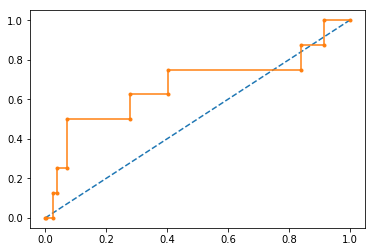

f1=0.000 auc=0.079 ap=0.098


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


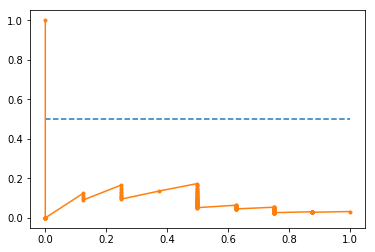

In [25]:




# calculate AUC
roc = m.roc_auc_score(test_Y, probs)
print('ROC_AUC: %.3f' % roc)
# calculate roc curve
fpr, tpr, thresholds = m.roc_curve(test_Y, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()



# calculate F1 score
f1 = m.f1_score(test_Y, yhat)
# calculate precision-recall AUC
auc = m.auc(recall, precision)
# calculate average precision score
ap = m.average_precision_score(test_Y, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()